In [686]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from autoencoder import create_encoders, create_conv_encoders, fit_encoders, create_full_model, fit_full_model, create_fc_layers
from preprocess import load_clean_data, data_stats, plot_samples, plot_avg, plot_ewma, create_features, create_features_labels 
from plots import plot_validation_diagram
from keras.layers import Dense, Input
from keras.models import Model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [687]:
data = load_clean_data([0, 1])
#validation = load_clean_data([3])

In [289]:
#data_stats(data)

In [158]:
#plot_samples(data)

In [159]:
#plot_avg(data[0]['signals'], 400)

In [160]:
#plot_ewma(data[0]['signals'], 400)

In [688]:
beats = create_features(data, 784)
x_train_beats, x_test_beats = train_test_split(beats, test_size = 0.2, random_state = 0)
features, labels = create_features_labels(data, 784)
lb = LabelBinarizer()
bin_labels = lb.fit_transform(labels)
x_train, x_test, y_train, y_test = train_test_split(features, bin_labels, test_size = 0.2, random_state = 0)

In [5]:
print(lb.classes_)

['A' 'N' 'NB']


In [689]:
ann = data[0]['annotations']
sig = data[0]['signals']

Successfully loaded weights


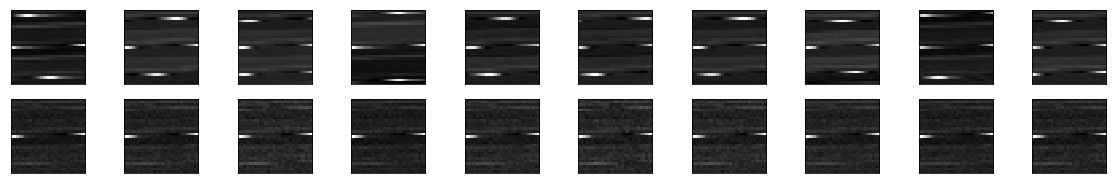

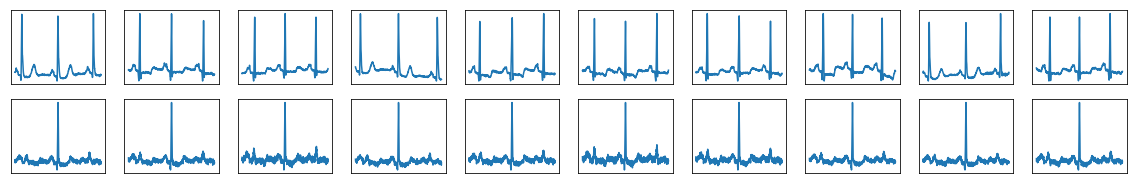

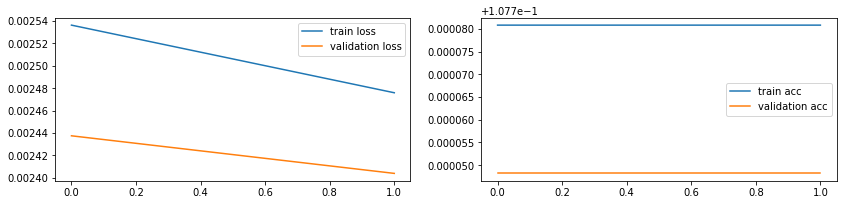

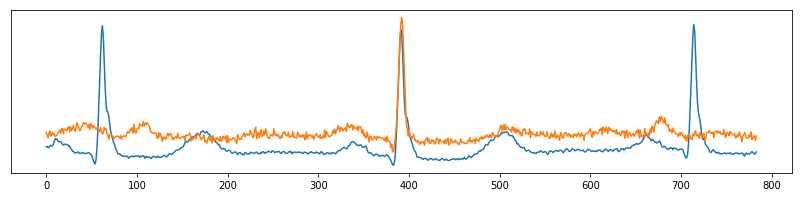

In [690]:
encoders = create_encoders(784, [], 64)
res = fit_encoders(encoders, x_train_beats, x_test_beats, epochs=2, filename='784_64.h5', load_prev=True)

In [692]:
full_model = create_full_model(encoders[1], layers_dim=[3])

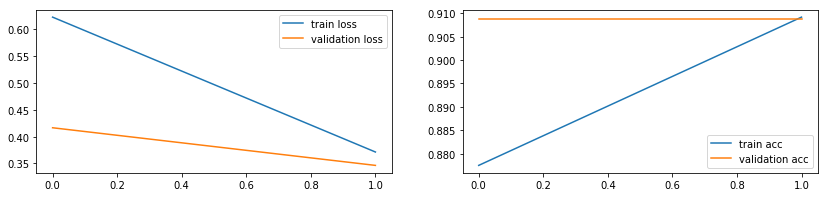

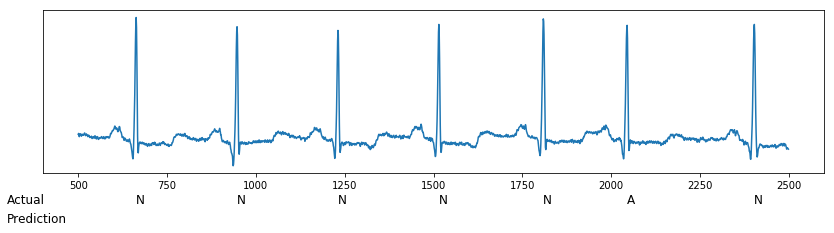

In [693]:
fit_full_model(full_model, x_train, x_test, y_train, y_test, epochs=2, verbose=0)
plot_validation_diagram(full_model, lb.classes_, ann, sig, 500, 2500)

### 784 256 128 64

Successfully loaded weights


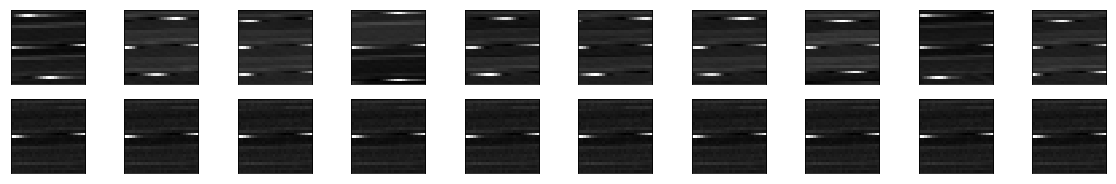

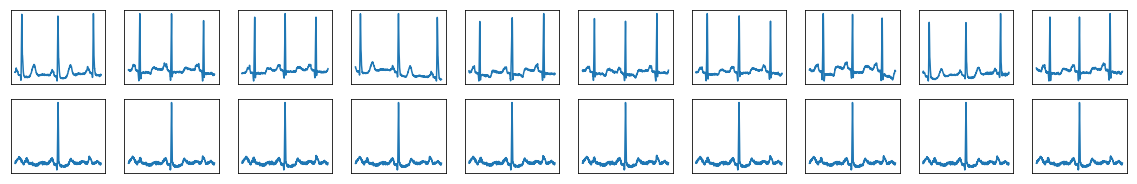

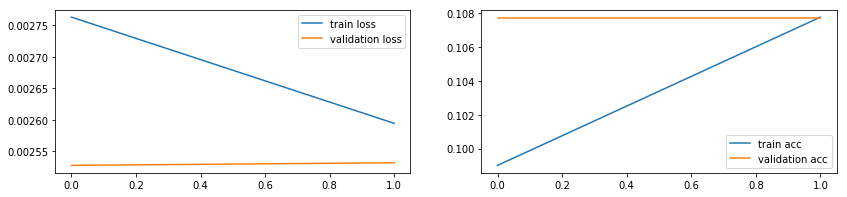

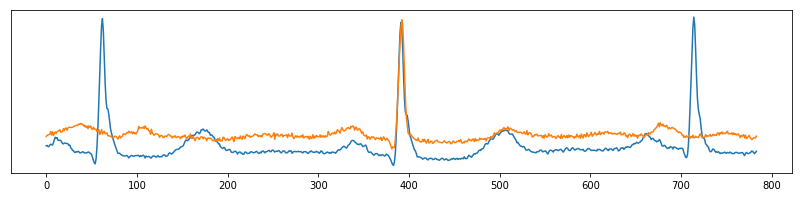

In [22]:
encoders = create_encoders(784, [256, 128], 64)
fit_encoders(encoders, x_train_beats, x_test_beats, epochs=2, filename='784_256_128_64.h5', load_prev=True)

In [34]:
full_model = create_full_model(encoders[1], layers_dim=[10, 3])

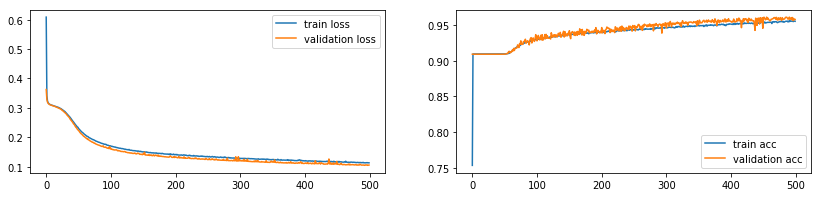

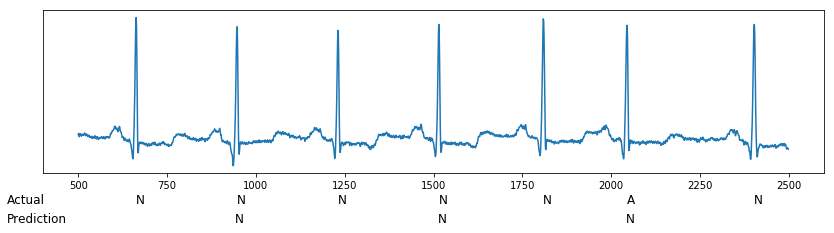

In [35]:
fit_full_model(full_model, x_train, x_test, y_train, y_test, epochs=500, verbose=0)
plot_validation_diagram(full_model, lb.classes_, ann, sig, 500, 2500)

In [36]:
full_model = create_full_model(encoders[1], layers_dim=[3])

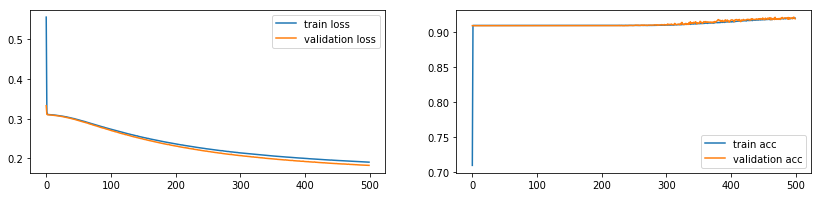

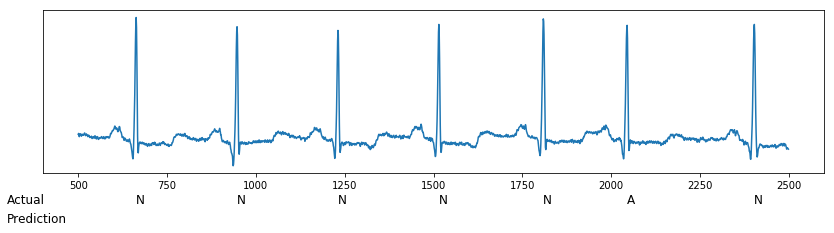

In [37]:
fit_full_model(full_model, x_train, x_test, y_train, y_test, epochs=500, verbose=0)
plot_validation_diagram(full_model, lb.classes_, ann, sig, 500, 2500)

### 784 512 64

Successfully loaded weights


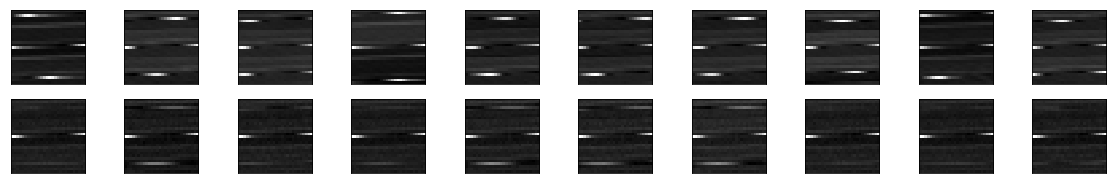

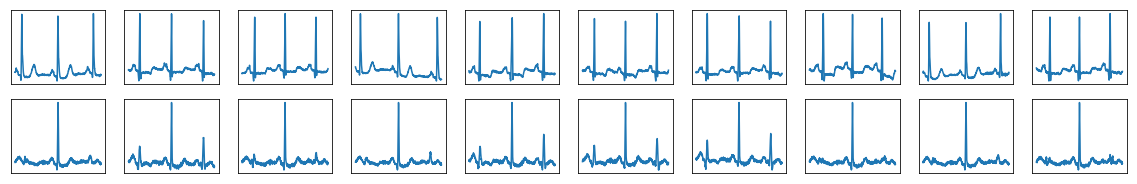

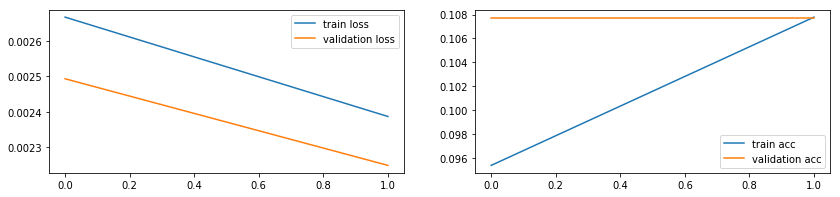

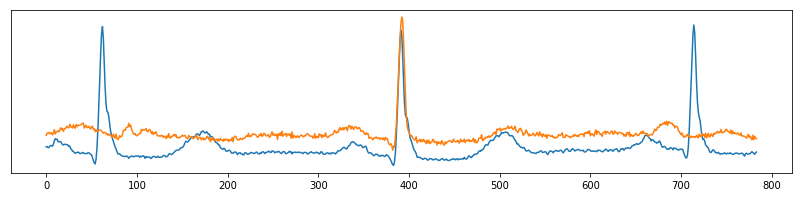

In [38]:
encoders = create_encoders(784, [512], 64)
fit_encoders(encoders, x_train_beats, x_test_beats, epochs=2, filename='784_512_64.h5', load_prev=True)

In [41]:
full_model = create_full_model(encoders[1], layers_dim=[10, 3])

Train on 36335 samples, validate on 9084 samples
Epoch 1/500
36335/36335 [==============================] - 0s - loss: 0.5240 - acc: 0.9091 - val_loss: 0.3886 - val_acc: 0.9089
Epoch 2/500
36335/36335 [==============================] - 0s - loss: 0.3610 - acc: 0.9092 - val_loss: 0.3442 - val_acc: 0.9089
Epoch 3/500
36335/36335 [==============================] - 0s - loss: 0.3335 - acc: 0.9092 - val_loss: 0.3266 - val_acc: 0.9089
Epoch 4/500
36335/36335 [==============================] - 0s - loss: 0.3215 - acc: 0.9092 - val_loss: 0.3182 - val_acc: 0.9089
Epoch 5/500
36335/36335 [==============================] - 0s - loss: 0.3155 - acc: 0.9092 - val_loss: 0.3136 - val_acc: 0.9089
Epoch 6/500
36335/36335 [==============================] - 0s - loss: 0.3121 - acc: 0.9092 - val_loss: 0.3107 - val_acc: 0.9089
Epoch 7/500
36335/36335 [==============================] - 0s - loss: 0.3098 - acc: 0.9092 - val_loss: 0.3086 - val_acc: 0.9089
Epoch 8/500
36335/36335 [==============================

36335/36335 [==============================] - 0s - loss: 0.1750 - acc: 0.9312 - val_loss: 0.1778 - val_acc: 0.9298
Epoch 128/500
36335/36335 [==============================] - 0s - loss: 0.1751 - acc: 0.9321 - val_loss: 0.1801 - val_acc: 0.9351
Epoch 129/500
36335/36335 [==============================] - 0s - loss: 0.1745 - acc: 0.9325 - val_loss: 0.1768 - val_acc: 0.9302
Epoch 130/500
36335/36335 [==============================] - 0s - loss: 0.1735 - acc: 0.9324 - val_loss: 0.1760 - val_acc: 0.9319
Epoch 131/500
36335/36335 [==============================] - 0s - loss: 0.1729 - acc: 0.9323 - val_loss: 0.1758 - val_acc: 0.9308
Epoch 132/500
36335/36335 [==============================] - 0s - loss: 0.1729 - acc: 0.9325 - val_loss: 0.1783 - val_acc: 0.9278
Epoch 133/500
36335/36335 [==============================] - 0s - loss: 0.1723 - acc: 0.9327 - val_loss: 0.1747 - val_acc: 0.9345
Epoch 134/500
36335/36335 [==============================] - 0s - loss: 0.1715 - acc: 0.9333 - val_loss:

36335/36335 [==============================] - 0s - loss: 0.1371 - acc: 0.9466 - val_loss: 0.1401 - val_acc: 0.9442
Epoch 254/500
36335/36335 [==============================] - 0s - loss: 0.1369 - acc: 0.9466 - val_loss: 0.1399 - val_acc: 0.9439
Epoch 255/500
36335/36335 [==============================] - 0s - loss: 0.1366 - acc: 0.9473 - val_loss: 0.1403 - val_acc: 0.9431
Epoch 256/500
36335/36335 [==============================] - 0s - loss: 0.1370 - acc: 0.9468 - val_loss: 0.1395 - val_acc: 0.9442
Epoch 257/500
36335/36335 [==============================] - 0s - loss: 0.1367 - acc: 0.9474 - val_loss: 0.1394 - val_acc: 0.9442
Epoch 258/500
36335/36335 [==============================] - 0s - loss: 0.1359 - acc: 0.9478 - val_loss: 0.1401 - val_acc: 0.9466
Epoch 259/500
36335/36335 [==============================] - 0s - loss: 0.1361 - acc: 0.9477 - val_loss: 0.1391 - val_acc: 0.9444
Epoch 260/500
36335/36335 [==============================] - 0s - loss: 0.1358 - acc: 0.9482 - val_loss:

36335/36335 [==============================] - 0s - loss: 0.1255 - acc: 0.9499 - val_loss: 0.1288 - val_acc: 0.9466
Epoch 380/500
36335/36335 [==============================] - 0s - loss: 0.1263 - acc: 0.9496 - val_loss: 0.1279 - val_acc: 0.9479
Epoch 381/500
36335/36335 [==============================] - 0s - loss: 0.1251 - acc: 0.9501 - val_loss: 0.1280 - val_acc: 0.9480
Epoch 382/500
36335/36335 [==============================] - 0s - loss: 0.1252 - acc: 0.9501 - val_loss: 0.1303 - val_acc: 0.9452
Epoch 383/500
36335/36335 [==============================] - 0s - loss: 0.1253 - acc: 0.9499 - val_loss: 0.1292 - val_acc: 0.9499
Epoch 384/500
36335/36335 [==============================] - 0s - loss: 0.1256 - acc: 0.9499 - val_loss: 0.1283 - val_acc: 0.9467
Epoch 385/500
36335/36335 [==============================] - 0s - loss: 0.1250 - acc: 0.9498 - val_loss: 0.1284 - val_acc: 0.9497
Epoch 386/500
36335/36335 [==============================] - 0s - loss: 0.1251 - acc: 0.9498 - val_loss:

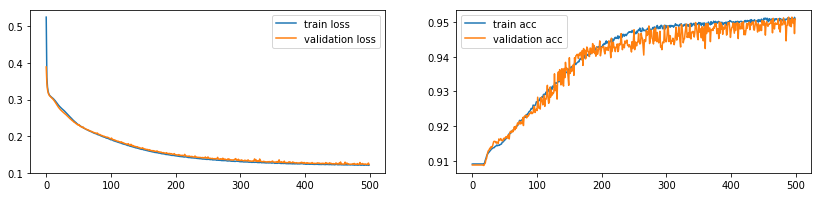

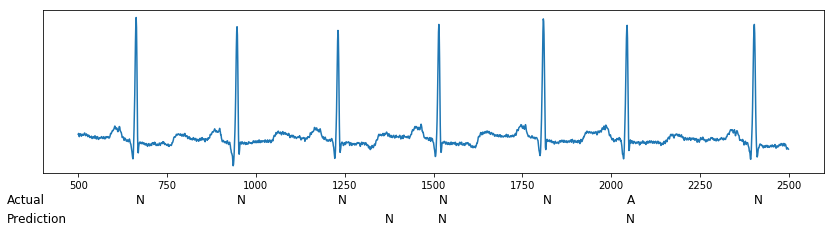

In [42]:
fit_full_model(full_model, x_train, x_test, y_train, y_test, epochs=500, verbose=1)
plot_validation_diagram(full_model, lb.classes_, ann, sig, 500, 2500)

### CONV

In [47]:
encoders = create_conv_encoders()

Successfully loaded weights


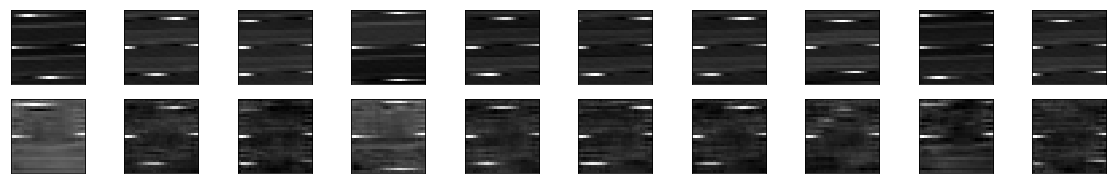

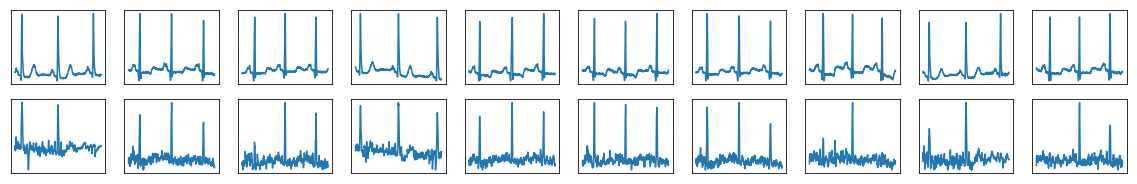

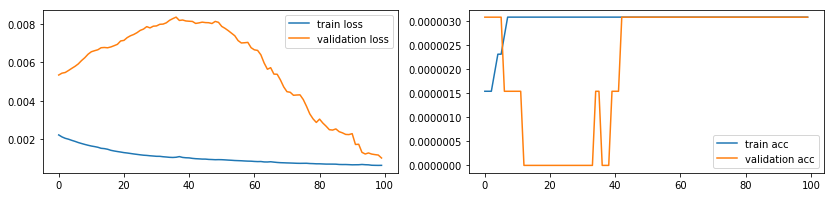

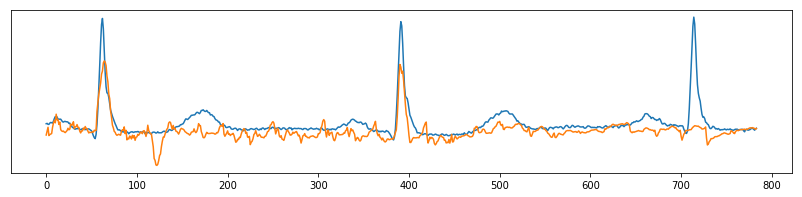

In [50]:
fit_encoders(encoders, x_train_beats, x_test_beats, epochs=100, filename='bn_conv16_8_8.h5', load_prev=True)

In [51]:
full_model = create_full_model(encoders[1], layers_dim=[10, 3])

In [52]:
fit_full_model(full_model, x_train, x_test, y_train, y_test, epochs=100, verbose=1)
plot_validation_diagram(full_model, lb.classes_, ann, sig, 500, 2500)

ValueError: Error when checking input: expected input_11 to have 4 dimensions, but got array with shape (36335, 784)

### Smooth data and bn

Can't load weights to model Unable to open file (Unable to open file: name = 'bn_smooth_data.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Train on 2235 samples, validate on 2235 samples
Epoch 1/1000
2235/2235 [==============================] - 1s - loss: 0.0167 - val_loss: 0.0084
Epoch 2/1000
2235/2235 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0082
Epoch 3/1000
2235/2235 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0080
Epoch 4/1000
2235/2235 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0080
Epoch 5/1000
2235/2235 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0079
Epoch 6/1000
2235/2235 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0079
Epoch 7/1000
2235/2235 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0078
Epoch 8/1000
2235/2235 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0078
Epoch 9/1000
2

2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0037
Epoch 85/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 86/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 87/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 88/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0035
Epoch 89/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 90/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 91/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 92/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 93/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 94/1000
2235/2235 [=============================

2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 253/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 254/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 255/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 256/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 257/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 258/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 259/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 260/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 261/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 262/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 421/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 422/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 423/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 424/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 425/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 426/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 427/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 428/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 429/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 430/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 9.1158e-04 - val_loss: 9.1698e-04
Epoch 581/1000
2235/2235 [==============================] - 0s - loss: 9.1125e-04 - val_loss: 9.1629e-04
Epoch 582/1000
2235/2235 [==============================] - 0s - loss: 9.1033e-04 - val_loss: 9.1134e-04
Epoch 583/1000
2235/2235 [==============================] - 0s - loss: 9.0921e-04 - val_loss: 9.1801e-04
Epoch 584/1000
2235/2235 [==============================] - 0s - loss: 9.0861e-04 - val_loss: 9.1092e-04
Epoch 585/1000
2235/2235 [==============================] - 0s - loss: 9.0807e-04 - val_loss: 9.1028e-04
Epoch 586/1000
2235/2235 [==============================] - 0s - loss: 9.0717e-04 - val_loss: 9.1201e-04
Epoch 587/1000
2235/2235 [==============================] - 0s - loss: 9.0602e-04 - val_loss: 9.1479e-04
Epoch 588/1000
2235/2235 [==============================] - 0s - loss: 9.0521e-04 - val_loss: 9.1107e-04
Epoch 589/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 8.0933e-04 - val_loss: 8.1062e-04
Epoch 737/1000
2235/2235 [==============================] - 0s - loss: 8.0885e-04 - val_loss: 8.1080e-04
Epoch 738/1000
2235/2235 [==============================] - 0s - loss: 8.0818e-04 - val_loss: 8.1295e-04
Epoch 739/1000
2235/2235 [==============================] - 0s - loss: 8.0765e-04 - val_loss: 8.0920e-04
Epoch 740/1000
2235/2235 [==============================] - 0s - loss: 8.0735e-04 - val_loss: 8.0786e-04
Epoch 741/1000
2235/2235 [==============================] - 0s - loss: 8.0657e-04 - val_loss: 8.0956e-04
Epoch 742/1000
2235/2235 [==============================] - 0s - loss: 8.0615e-04 - val_loss: 8.0733e-04
Epoch 743/1000
2235/2235 [==============================] - 0s - loss: 8.0540e-04 - val_loss: 8.1024e-04
Epoch 744/1000
2235/2235 [==============================] - 0s - loss: 8.0509e-04 - val_loss: 8.0603e-04
Epoch 745/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 7.3131e-04 - val_loss: 7.3064e-04
Epoch 893/1000
2235/2235 [==============================] - 0s - loss: 7.3046e-04 - val_loss: 7.3061e-04
Epoch 894/1000
2235/2235 [==============================] - 0s - loss: 7.2993e-04 - val_loss: 7.2975e-04
Epoch 895/1000
2235/2235 [==============================] - 0s - loss: 7.2927e-04 - val_loss: 7.3114e-04
Epoch 896/1000
2235/2235 [==============================] - 0s - loss: 7.2912e-04 - val_loss: 7.3010e-04
Epoch 897/1000
2235/2235 [==============================] - 0s - loss: 7.2835e-04 - val_loss: 7.2863e-04
Epoch 898/1000
2235/2235 [==============================] - 0s - loss: 7.2820e-04 - val_loss: 7.2792e-04
Epoch 899/1000
2235/2235 [==============================] - 0s - loss: 7.2780e-04 - val_loss: 7.2789e-04
Epoch 900/1000
2235/2235 [==============================] - 0s - loss: 7.2720e-04 - val_loss: 7.2774e-04
Epoch 901/1000
2235/2235 [==============================] - 0s - loss:

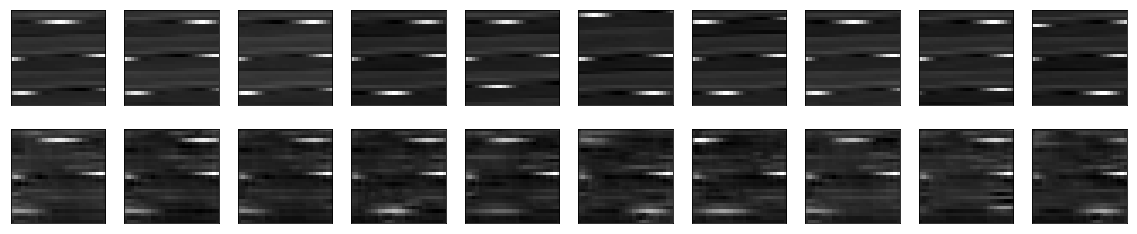

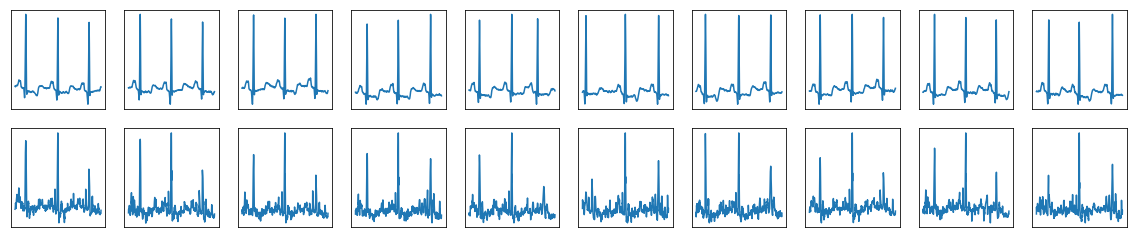

CPU times: user 10min 59s, sys: 1min 43s, total: 12min 43s
Wall time: 13min 32s


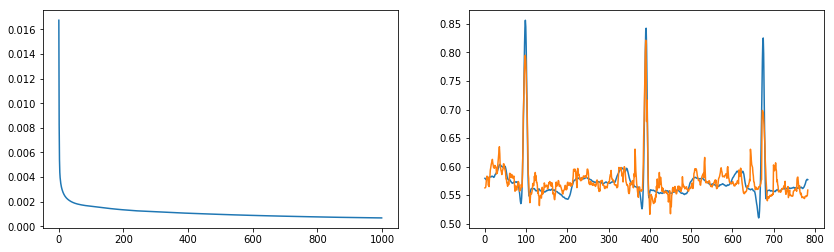

In [64]:
%time run(*create_conv_encoders(), shape=(28,28,1), weights_filename = 'bn_smooth_data.h5', epochs=1000)